# Model nhận dạng hãng xe(Toyota, Ford, Mer, Hyun)

In [1]:
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lấy data đã scrapy về trên web

In [3]:
raw_folder = "/content/drive/MyDrive/Data-ML-Drive/CAR/download/download"

In [4]:
def save_data(raw_folder=raw_folder):
    dest_size=(128,128)
    print("Start Processing")
    pixels = []
    labels = []

    #load tung thu muc con
    for folder in listdir(raw_folder):
        if folder!='.DS_Store':
            print("Folder=", folder)
            # load cac anh
            for file in listdir(raw_folder+"/"+folder):
                print("File=",file)
                pixels.append(cv2.resize(cv2.imread(raw_folder+"/" + folder+ "/"+file), dsize=(dest_size)))#doc cac anh va luu lam pixels
                labels.append(folder)#lay labels la cac thu muc con chua cac anh

    pixels=np.array(pixels)
    labels = np.array(labels) #reshape(-1,1)

    from sklearn.preprocessing import LabelBinarizer
    encoder = LabelBinarizer()
    labels = encoder.fit_transform(labels)
    # print(labels)

    file = open('pix.data', 'wb')
    # ket xuat thong tin vao tep do
    pickle.dump((pixels, labels), file)
    # dong file
    file.close()
    return

def load_data():
    file = open('pix.data', 'rb')
    (pixels, labels)= pickle.load(file)
    file.close()
    # print(pixels.shape)
    # print(labels.shape)
    return pixels, labels

In [5]:
save_data()
X,y=load_data()
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=100)
print(X_train.shape)
print(y_train.shape)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
File= 1001.jpg
File= 1009.jpg
File= 1011.jpg
File= 1006.jpg
File= 1007.jpg
File= 1003.jpg
File= 1008.jpg
File= 1005.jpg
File= 1018.jpg
File= 1016.jpg
File= 1017.jpg
File= 1019.jpg
File= 1013.jpg
File= 1020.jpg
File= 1014.jpg
File= 1015.jpg
File= 1024.jpg
File= 1036.jpg
File= 1026.jpg
File= 1031.jpg
File= 1037.jpg
File= 1023.jpg
File= 1021.jpg
File= 1032.jpg
File= 1029.jpg
File= 1027.jpg
File= 1030.jpg
File= 1034.jpg
File= 1033.jpg
File= 1028.jpg
File= 1025.jpg
File= 1022.jpg
File= 1035.jpg
File= 1038.jpg
File= 1046.jpg
File= 1043.jpg
File= 1040.jpg
File= 1041.jpg
File= 1045.jpg
File= 1039.jpg
File= 1047.jpg
File= 1042.jpg
File= 1044.jpg
File= 1059.jpg
File= 1057.jpg
File= 1051.jpg
File= 1048.jpg
File= 1050.jpg
File= 1056.jpg
File= 1049.jpg
File= 1055.jpg
File= 1060.jpg
File= 1054.jpg
File= 1058.jpg
File= 1053.jpg
File= 1052.jpg
File= 1070.jpg
File= 1069.jpg
File= 1071.jpg
File= 1062.jpg
File= 1061.jpg
File= 1068.jpg
File= 1063.jp

# Built model

In [6]:
def get_model():
    model_vgg16_conv=VGG16(weights='imagenet', include_top=False)

    #dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable=False

    #tao model
    input = Input(shape=(128,128,3), name='image_input')
    output_vgg16_conv=model_vgg16_conv(input)

    #them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax', name='predictions')(x)

    #compile
    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return my_model

In [7]:
vggmodel = get_model()

58889256/58889256 [==============================] - 0s 0us/step


# Làm giàu dữ liệu ảnh, do số lượng ảnh scrapy không quá nhiều

# Training

In [8]:
filepath = "weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#xay dung dao tao hinh anh de tang cuong du lieu
aug = ImageDataGenerator(
                         rotation_range=10,
                         zoom_range=0.1,
                         rescale=1./255,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         #horizontal_flip=True,
                         brightness_range=[0.2,1.5],
                         fill_mode="nearest",
                         #shear_range = 1
                         )
#aug_val=ImageDataGenerator(rescale=1./255)
train_generator = aug.flow(X_train, y_train,batch_size= 32,shuffle=True, seed = 42)
n_augmented_images = train_generator.n
print(n_augmented_images)
vggmodel.fit_generator(train_generator, epochs= 10, validation_data = aug.flow(X_test, y_test, batch_size=32), callbacks=callbacks_list)

5792


<ipython-input-8-33396d96acfe>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vggmodel.fit_generator(train_generator, epochs= 10, validation_data = aug.flow(X_test, y_test, batch_size=32), callbacks=callbacks_list)


Epoch 1/10
181/181 [==============================] - ETA: 0s - loss: 1.8044 - accuracy: 0.3636
Epoch 1: val_accuracy improved from -inf to 0.48895, saving model to weights-01-0.4890.hdf5
181/181 [==============================] - 59s 263ms/step - loss: 1.8044 - accuracy: 0.3636 - val_loss: 1.1516 - val_accuracy: 0.4890
Epoch 2/10
181/181 [==============================] - ETA: 0s - loss: 1.2137 - accuracy: 0.4372
Epoch 2: val_accuracy improved from 0.48895 to 0.50552, saving model to weights-02-0.5055.hdf5
181/181 [==============================] - 46s 253ms/step - loss: 1.2137 - accuracy: 0.4372 - val_loss: 1.1285 - val_accuracy: 0.5055
Epoch 3/10
181/181 [==============================] - ETA: 0s - loss: 1.1775 - accuracy: 0.4634
Epoch 3: val_accuracy improved from 0.50552 to 0.53246, saving model to weights-03-0.5325.hdf5
181/181 [==============================] - 39s 216ms/step - loss: 1.1775 - accuracy: 0.4634 - val_loss: 1.0966 - val_accuracy: 0.5325
Epoch 4/10
181/181 [========

In [10]:
vggmodel.fit(X_train, y_train, validation_data = (X_test, y_test),batch_size=32, epochs = 10,callbacks=callbacks_list)

Epoch 1/10
180/181 [============================>.] - ETA: 0s - loss: 0.8519 - accuracy: 0.6951
Epoch 1: val_accuracy did not improve from 0.69406
181/181 [==============================] - 11s 62ms/step - loss: 0.8535 - accuracy: 0.6946 - val_loss: 0.7684 - val_accuracy: 0.6941
Epoch 2/10
181/181 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.7041
Epoch 2: val_accuracy did not improve from 0.69406
181/181 [==============================] - 12s 65ms/step - loss: 0.8279 - accuracy: 0.7041 - val_loss: 0.7934 - val_accuracy: 0.6837
Epoch 3/10
181/181 [==============================] - ETA: 0s - loss: 0.7812 - accuracy: 0.7144
Epoch 3: val_accuracy did not improve from 0.69406
181/181 [==============================] - 12s 67ms/step - loss: 0.7812 - accuracy: 0.7144 - val_loss: 0.8031 - val_accuracy: 0.6920
Epoch 4/10
181/181 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.7117
Epoch 4: val_accuracy improved from 0.69406 to 0.69959, saving m

In [ ]:
#vggmodel.fit_generator(train_generator, epochs= 10, validation_data = aug.flow(X_test, y_test, batch_size=32), callbacks=callbacks_list)

In [11]:
vggmodel.save("vggmodel.h5")

In [13]:
import os
filesize = os.path.getsize('/content/weights-10-0.6941.hdf5')
print(f'Kích thước của tập tin là {filesize} bytes.')
KB = 1024
MB = KB * 1024
GB = MB * 1024

filesize_in_kb = filesize / KB
filesize_in_mb = filesize / MB
filesize_in_gb = filesize / GB
print(filesize_in_gb)

Kích thước của tập tin là 663214424 bytes.
0.6176665648818016


In [15]:
my_model = get_model()
my_model.load_weights("/content/weights-08-0.6837.hdf5")

# Kiểm tra model

In [ ]:
# get image
%cd /content
!mkdir test_images
%cd test_images
!wget https://ims.baoyenbai.com.vn/NewsImg/3_2023/271682_24-3-cam-ry.jpg

<function matplotlib.pyplot.show(close=None, block=None)>

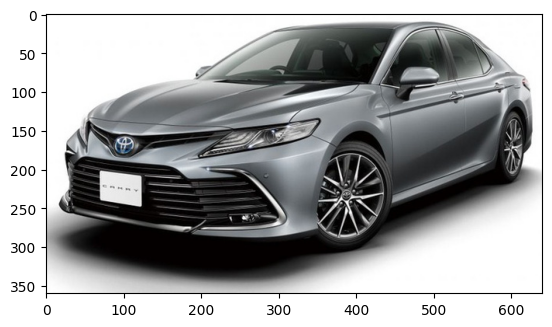

In [23]:
path = '/content/test_images/271682_24-3-cam-ry.jpg'
from PIL import Image
image = Image.open(path)
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show

In [22]:
image_org = cv2.imread('/content/test_images/271682_24-3-cam-ry.jpg')
image_org = cv2.resize(image_org, dsize=None,fx=0.5,fy=0.5)
# Resize
image = image_org.copy()
image = cv2.resize(image, dsize=(128, 128))
image = image.astype('float')*1./255
# Convert to tensor
image = np.expand_dims(image, axis=0)
class_name = ['ford', 'huyn', 'mer', 'toyota']
# Predict
predict = my_model.predict(image)
# print("This picture is: ", class_name[np.argmax(predict[0])])
print(np.max(predict[0]))
#if (np.max(predict)>=0.8) :
# Show image
    
print(class_name[np.argmax(predict[0])])

1/1 [==============================] - 0s 28ms/step
0.29132587
toyota


# Model nhận diện màu xe 

#Gom cac label cho Color(để dễ trail)


#Label1: mau trang + mau bac + mau ghi + mau kem + mau xam

df['Color'].replace('màu trắng', 'label1', inplace=True)

df['Color'].replace('màu bạc', 'label1', inplace=True)

df['Color'].replace('màu ghi', 'label1', inplace=True)

df['Color'].replace('màu kem', 'label1', inplace=True)

df['Color'].replace('màu xám', 'label1', inplace=True)

#Label2: mau den

df['Color'].replace('màu đen', 'label2', inplace=True)

#Label3: mau do + mau nau + mau cam + mau vang + mau cat + mau dong
df['Color'].replace('màu đỏ', 'label3', inplace=True)

df['Color'].replace('màu nâu', 'label3', inplace=True)

df['Color'].replace('màu cam', 'label3', inplace=True)

df['Color'].replace('màu vàng', 'label3', inplace=True)

df['Color'].replace('màu cát', 'label3', inplace=True)

df['Color'].replace('màu đồng', 'label3', inplace=True)


#Label4: mau xanh + các màu ko xác định
df['Color'].replace('màu xanh', 'label4', inplace=True)

df['Color'].replace('máy xăng 4.0 L', 'label4', inplace=True)

df['Color'].replace('máy xăng 3.0 L', 'label4', inplace=True)

df['Color'].replace('máy xăng', 'label4', inplace=True)

df['Color'].replace('máy xăng 4.7 L', 'label4', inplace=True)

df['Color'].replace('máy xăng 1.5 L', 'label4', inplace=True)

df['Color'].replace('máy dầu 2.2 L', 'label4', inplace=True)

df['Color'].replace('máy dầu 2.0 L', 'label4', inplace=True)

df['Color'].replace('máy dầu 3.2 L', 'label4', inplace=True)

df['Color'].replace('màu hồng', 'label4', inplace=True)

df['Color'].replace('màu tím', 'label4', inplace=True)




# Lấy data đã thu thập trên web

In [25]:
import pandas as pd
df= pd.read_csv('/content/file_new.csv')

In [26]:

T = []
Toyota_rows = df.loc[df['Mode'] == 'Toyota']
car_color_values1 = Toyota_rows['Color']
for i in range(0, len(car_color_values1)):
  T.append(car_color_values1.iloc[i])
print(T)
print(len(T))

F = []
Ford_rows = df.loc[df['Mode'] == 'Ford']
car_color_values2 = Ford_rows['Color']
for i in range(0, len(car_color_values2)):
  F.append(car_color_values2.iloc[i])
print(F)
print(len(F))

H = []
Toyota_rows = df.loc[df['Mode'] == 'Hyundai']
car_color_values3 = Toyota_rows['Color']
for i in range(0, len(car_color_values3)):
  H.append(car_color_values3.iloc[i])
print(H)
print(len(H))

M = []
Toyota_rows = df.loc[df['Mode'] == 'Mercedes']
car_color_values4 = Toyota_rows['Color']
for i in range(0, len(car_color_values4)):
  M.append(car_color_values4.iloc[i])
print(M)
print(len(M))

#gop mang 
T = np.array(T)
F= np.array(F)
H = np.array(H)
M = np.array(M)

labels_color = np.concatenate((M, H, T, F))
print(len(labels_color))
print(labels_color)


['label1', 'label1', 'label1', 'label1', 'label2', 'label2', 'label1', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label1', 'label1', 'label2', 'label1', 'label1', 'label2', 'label2', 'label2', 'label2', 'label1', 'label2', 'label2', 'label1', 'label1', 'label2', 'label2', 'label1', 'label1', 'label1', 'label2', 'label2', 'label1', 'label1', 'label1', 'label1', 'label2', 'label1', 'label1', 'label1', 'label1', 'label1', 'label2', 'label2', 'label2', 'label1', 'label1', 'label1', 'label1', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label3', 'label2', 'label2', 'label2', 'label1', 'label2', 'label1', 'label1', 'label1', 'label2', 'label2', 'label2', 'label2', 'label1', 'label1', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label2', 'label1', 'label1', 'label2', 'label1', 'label2', 'label2', 'label2', 'label1', 'label2', 'label1', 'label1', 'label1', 'label2', 'label1', 'label1',

In [ ]:
#train mau cho tap du lieu
def save_data(raw_folder=raw_folder):
    dest_size=(128,128)
    print("Start Processing")
    pixels = []

    #load tung thu muc con
    for folder in listdir(raw_folder):
        if folder!='.DS_Store':
            print("Folder=", folder)
            # load cac anh
            file_sorted = sorted(listdir(raw_folder+"/"+folder), key=lambda x: int(x.split('.')[0]))
            for file in  file_sorted:
                print("File=",file)
                pixels.append(cv2.resize(cv2.imread(raw_folder+"/" + folder+ "/"+file), dsize=(dest_size)))#doc cac anh va luu lam pixels

    pixels=np.array(pixels) 
    labels_color = np.concatenate((M, H, T, F))

    from sklearn.preprocessing import LabelBinarizer
    encoder = LabelBinarizer()
    labels_color = encoder.fit_transform(labels_color)
    # print(labels)

    file = open('pix_color.data', 'wb')
    # ket xuat thong tin vao tep do
    pickle.dump((pixels, labels_color), file)
    # dong file
    file.close()
    return

def load_data():
    file = open('pix_color.data', 'rb')
    (pixels, labels_color)= pickle.load(file)
    file.close()
    # print(pixels.shape)
    # print(labels.shape)
    return pixels, labels_color

In [ ]:
save_data()
X,y=load_data()
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=100)
print(X_train.shape)
print(y_train.shape)


In [ ]:
print(y_train[10:20])
# 1000: labels1
# 0100: labels2,...

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]]


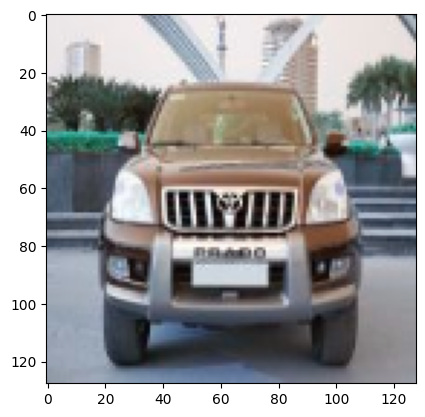

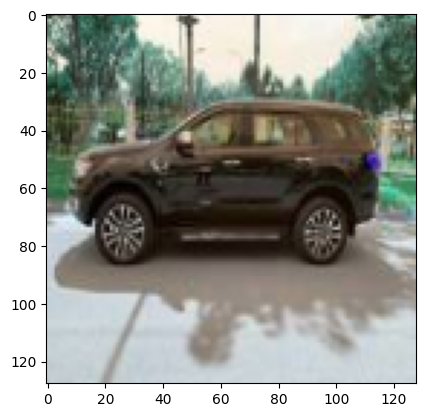

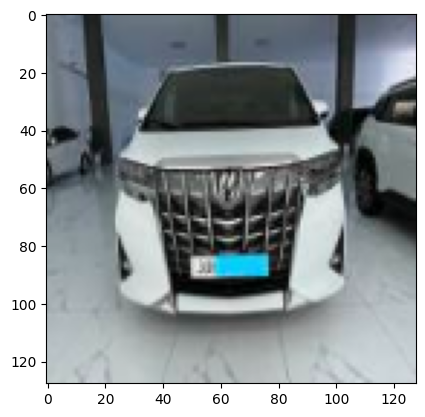

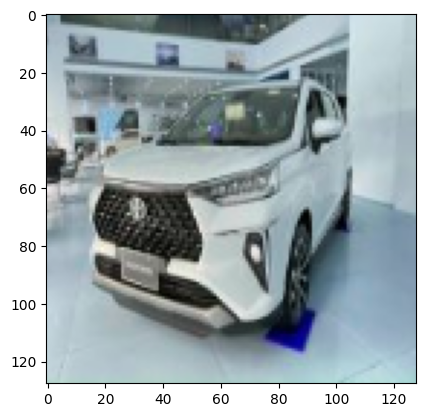

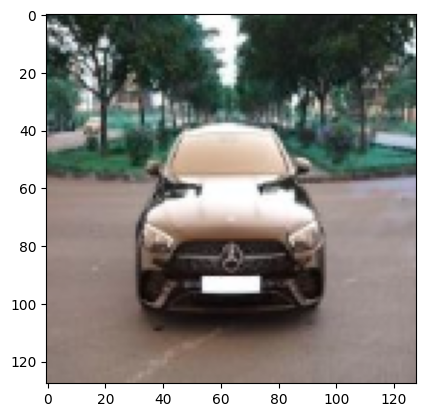

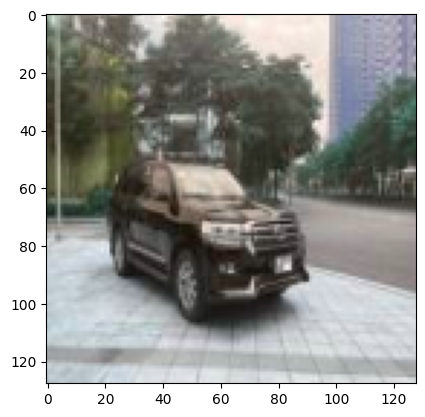

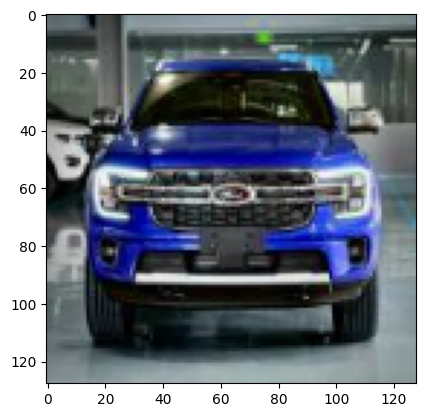

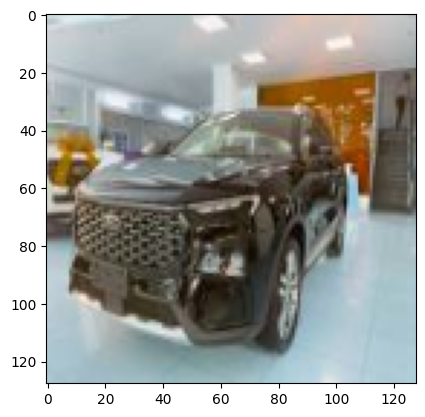

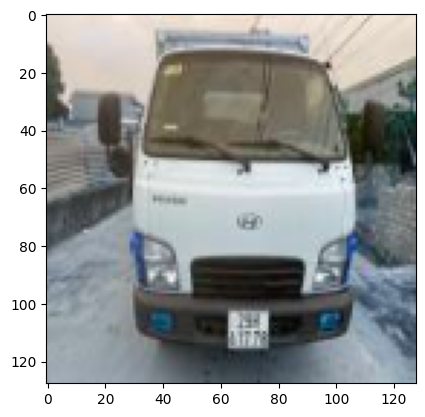

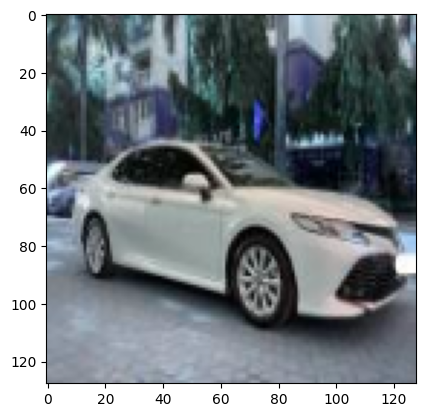

In [ ]:
for i in range(10,20):
    plt.imshow(X_train[i])
    plt.show()

# Built model

In [ ]:
def get_model():
    model_vgg16_conv=VGG16(weights='imagenet', include_top=False)

    #dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable=False

    #tao model
    input = Input(shape=(128,128,3), name='image_input')
    output_vgg16_conv=model_vgg16_conv(input)

    #them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax', name='predictions')(x)

    #compile
    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return my_model

In [ ]:
vggmodel = get_model()

In [ ]:
filepath = "weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#xay dung dao tao hinh anh de tang cuong du lieu
aug = ImageDataGenerator(
                         rotation_range=10,
                         zoom_range=0.1,
                         rescale=1./255,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         #horizontal_flip=True,
                         #brightness_range=[0.2,1.5],
                         fill_mode="nearest",
                         #shear_range = 1
                         )
#aug_val=ImageDataGenerator(rescale=1./255)
train_generator = aug.flow(X_train, y_train,batch_size= 32,shuffle=True, seed = 42)
n_augmented_images = train_generator.n
print(n_augmented_images)
vggmodel.fit_generator(train_generator, epochs= 10, validation_data = aug.flow(X_test, y_test, batch_size=32), callbacks=callbacks_list)

5792
Epoch 1/10


<ipython-input-15-be479bf3f562>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vggmodel.fit_generator(train_generator, epochs= 10, validation_data = aug.flow(X_test, y_test, batch_size=32), callbacks=callbacks_list)


181/181 [==============================] - ETA: 0s - loss: 1.2314 - accuracy: 0.6689
Epoch 1: val_accuracy improved from -inf to 0.80318, saving model to weights-01-0.8032.hdf5
181/181 [==============================] - 51s 217ms/step - loss: 1.2314 - accuracy: 0.6689 - val_loss: 0.6213 - val_accuracy: 0.8032
Epoch 2/10
181/181 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.7516
Epoch 2: val_accuracy improved from 0.80318 to 0.80387, saving model to weights-02-0.8039.hdf5
181/181 [==============================] - 34s 189ms/step - loss: 0.7178 - accuracy: 0.7516 - val_loss: 0.5987 - val_accuracy: 0.8039
Epoch 3/10
181/181 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.7579
Epoch 3: val_accuracy improved from 0.80387 to 0.80663, saving model to weights-03-0.8066.hdf5
181/181 [==============================] - 42s 232ms/step - loss: 0.6981 - accuracy: 0.7579 - val_loss: 0.6420 - val_accuracy: 0.8066
Epoch 4/10
181/181 [===================

In [ ]:
import os
filesize = os.path.getsize('/content/weights-08-0.8301.hdf5')
print(f'Kích thước của tập tin là {filesize} bytes.')
KB = 1024
MB = KB * 1024
GB = MB * 1024

filesize_in_kb = filesize / KB
filesize_in_mb = filesize / MB
filesize_in_gb = filesize / GB
print(filesize_in_gb)

Kích thước của tập tin là 663214464 bytes.
0.6176666021347046


In [ ]:
my_model = get_model()
my_model.load_weights("/content/weights-08-0.8301.hdf5")

In [ ]:
# get image
%cd /content
!mkdir test_images
%cd test_images
!wget https://static.danhgiaxe.com/data/201525/the-rczs-soft-flowing-curves-and-classic-double-bubble-roofline-make-for-one-gorgeous-silhouette_2678.jpg

<function matplotlib.pyplot.show(close=None, block=None)>

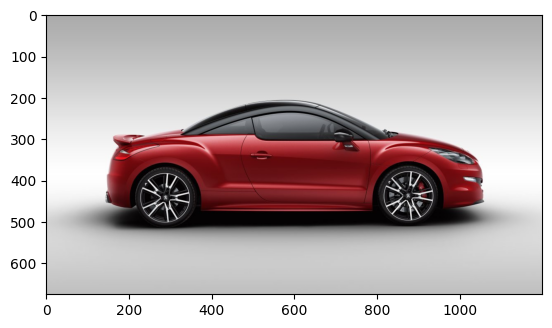

In [28]:
path = '/content/test_images/the-rczs-soft-flowing-curves-and-classic-double-bubble-roofline-make-for-one-gorgeous-silhouette_2678.jpg'
from PIL import Image
image = Image.open(path)
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show

In [ ]:
import cv2
image_org = cv2.imread('/content/339282449_1579094582594679_1183387903962155835_n.png')
image_org = cv2.resize(image_org, dsize=None,fx=0.5,fy=0.5)
# Resize
image = image_org.copy()
image = cv2.resize(image, dsize=(128, 128))
image = image.astype('float')*1./255
# Convert to tensor
image = np.expand_dims(image, axis=0)
class_name = ['1', '2', '3', '4']
# Predict
predict = my_model.predict(image)
# print("This picture is: ", class_name[np.argmax(predict[0])])
print(np.max(predict[0]))
#if (np.max(predict)>=0.8) :
# Show image
    
print(class_name[np.argmax(predict[0])])


1/1 [==============================] - 0s 32ms/step
0.9986045
3
